In [1]:
!pip install numpy pandas matplotlib

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from typing import List
import re

In [129]:
def plot_and_save(data, metric, save_path, suffix):
    plt.figure(figsize=(10, 6))  # Adjust figure size for better visibility of labels
    
    # Filter out rows where 'y' is not equal to 0
    filtered_data = data[data[metric] != 0]

    # Plot the metric over time using filtered data
    plt.plot(filtered_data['time'], filtered_data[metric], label=metric.capitalize())
    
    # Calculate and annotate peak value on the filtered data
    peak_value = filtered_data[metric].max()
    peak_time = filtered_data['time'][filtered_data[metric].idxmax()]
    plt.annotate(f'Peak: {peak_value}', xy=(peak_time, peak_value), xytext=(peak_time, peak_value + (peak_value * 0.1)),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )
    
    # Calculate and plot average value on the filtered data
    avg_value = filtered_data[metric].mean()
    plt.axhline(y=avg_value, color='r', linestyle='-', label=f'Average: {avg_value:.2f}')
    
    # Setting labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} over Time")
    plt.legend()

    # Define the number of ticks: quarters (4) or eighths (8)
    num_ticks = 8  # Change this to 4 for quarters if preferred

    # Get current x-axis tick locations and labels
    x_ticks = np.linspace(start=0, stop=len(filtered_data['time']) - 1, num=num_ticks, dtype=int)
    x_labels = [filtered_data['time'].iloc[i] for i in x_ticks]  # Get the labels for the new ticks
    
    # Set the new ticks and labels
    plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

    # Save the plot
    plt.savefig(os.path.join(save_path, f"{metric}_plot-{suffix}.png"), bbox_inches='tight')  # bbox_inches='tight' for fitting the rotated labels
    
    # Close the plot figure to free memory
    plt.close()


In [67]:
def get_last_line(filename):
    with open(filename, 'rb') as f:
        f.seek(-2, os.SEEK_END)  # Jump to the second last byte
        while f.read(1) != b'\n':  # Keep reading backwards until you find the first newline character
            f.seek(-2, os.SEEK_CUR) 
        last_line = f.readline().decode()  # Decode to convert from bytes to string
    return last_line

In [155]:
def traverse_and_process(root_directory):
    pattern = r"torch\.distributed\.elastic\.multiprocessing\.api\.SignalException: Process .* got signal: 15"
    prefix = "failed_"
    failed_list = []
    succeeded = {"gpu": {}, "ntwk": {}}
    for root, dirs, files in os.walk(root_directory):
        torchrun_logfiles = [file for file in files if file.startswith("torchrun") and file.endswith(".log")]
        failed = False
        if len(torchrun_logfiles) > 0:
            for f in torchrun_logfiles:
                if not re.search(pattern,get_last_line(os.path.join(root, f))): 
                    failed = True
        else:
            print("found no torchrun log file in ", root)
            continue
        if failed:
            #rename the directore to failed_<dirname>
            head, tail = os.path.split(root)
            new_name = prefix + tail
            new_dir_path = os.path.join(head, new_name)
            os.rename(root, new_dir_path)
            failed_list.append(new_dir_path)
            continue
        files = [file for file in files if file.endswith(".csv")]
        run_info = "-".join((os.path.basename(root)).split("-")[2:])
        succeeded["gpu"][run_info] = []
        succeeded["ntwk"][run_info] = []
        for file in files:
            if file.startswith("nvidia-smi"): 
                full_path = os.path.join(root, file)
                gpu_data = pd.read_csv(full_path)[['timestamp', ' utilization.gpu [%]', ' utilization.memory [%]', ' memory.used [MiB]', ' memory.free [MiB]']]
                gpu_data.rename(columns={'timestamp': 'time'}, inplace=True)
                gpu_data = gpu_data.replace(to_replace=r'(%|MiB|W)', value='', regex=True)

                # Convert all columns to string and strip whitespace from each element
                gpu_data = gpu_data.apply(lambda x: x.astype(str).str.strip())

                # Strip whitespace from column names
                gpu_data.columns = [col.strip() for col in gpu_data.columns]
                gpu_data.attrs['name'] = file.split(".")[0]
                gpu_data[['utilization.gpu [%]', 'utilization.memory [%]', 'memory.used [MiB]', 'memory.free [MiB]']] = \
                    gpu_data[['utilization.gpu [%]', 'utilization.memory [%]', 'memory.used [MiB]', 'memory.free [MiB]']].apply(pd.to_numeric)
                succeeded["gpu"][run_info].append(gpu_data)
                suffix = file.split('-')[2].split(".")[0]
                for metric in ['utilization.gpu [%]', 'utilization.memory [%]', 'memory.used [MiB]']:
                    plot_and_save(gpu_data, metric, root, suffix)
                    
            elif file.startswith("dool"):
                full_path = os.path.join(root, file)
                ntwk_data = pd.read_csv(full_path, skiprows=5)
                ntwk_data = ntwk_data[['time', 'recv', 'send']]
                ntwk_data.attrs['name'] = file.split(".")[0]
                succeeded["ntwk"][run_info].append(ntwk_data)
                suffix = file.split('-')[1].split(".")[0]
                for metric in ['recv', 'send']:
                    plot_and_save(ntwk_data, metric, root, suffix)

    return succeeded, failed_list


In [156]:
succeeded, failed = traverse_and_process("/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041")

found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041
found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305191041-basic_prof-pp1-tp1/orchestrator-log
found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305195316-basic_prof-cpuinit-pp1-tp4/orchestrator-log
found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305221805-basic_prof-ra-pp1-tp2/orchestrator-log
found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305201018-basic_prof-cpuinit-pp1-tp8/orchestrator-log
found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305232614-basic_prof-ra-pp2-tp2/orchestrator-log
found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/failed_240306003423-basic_prof-ra-pp8-tp1/orchestrator-log
found no torchrun log file in  /Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/failed_240306013401-basic_prof-dsa-cpuinit-pp1-tp8/orchest

In [131]:
failed_list

['/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240306013401-basic_prof-dsa-cpuinit-pp1-tp8',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240306005125-basic_prof-dsa-pp1-tp2',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240306010827-basic_prof-dsa-pp1-tp4',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240306015103-basic_prof-dsa-cpuinit-pp2-tp2',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305214401-basic_prof-pp8-tp1',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240306004254-basic_prof-ra-cpuinit-pp8-tp1',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240306021636-basic_prof-dsa-pp4-tp2',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305211827-basic_prof-cpuinit-pp4-tp1',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240306022508-basic_prof-dsa-cpuinit-pp4-tp2',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305202721-basic_prof-cpuinit-pp2-tp1',
 '/Users/kite/Haoyu/runs/gpt3-1.3B-240305191041/240305220103-basic_prof-ra-pp1-tp1',
 '/Users/kite/Haoyu/

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List

def get_global_rankings(dfs_dict: Dict[str, List[pd.DataFrame]], col: str, node_metric: str, run_metric: str, reverse=True):
    # Process each run using the node_metric and then aggregate across runs with the run_metric
    run_aggregated_metrics = {}
    for run_name, dfs in dfs_dict.items():
        # Calculate the node_metric for each DataFrame within a run
        node_metrics = [getattr(df[col], node_metric)() for df in dfs]
        
        # Use a Series to apply the run_metric to the list of node_metrics
        aggregated_metric = getattr(pd.Series(node_metrics), run_metric)()
        
        # Simplify the run name if needed
        experiment_name = run_name
        run_aggregated_metrics[experiment_name] = aggregated_metric

    # Sort the processed metrics based on their aggregated values
    sorted_metrics = sorted(run_aggregated_metrics.items(), key=lambda x: x[1], reverse=reverse)

    # Plotting
    plt.figure(figsize=(20, 6))
    experiment_names, metric_values = zip(*sorted_metrics)  # Unpacking for plotting

    # Plot each run's aggregated metric value
    plt.bar(experiment_names, metric_values)

    # Adjust x-axis labels for clarity
    plt.xticks(rotation=45, ha='right')

    plt.xlabel('Experiment Name')
    plt.ylabel(f'{run_metric.capitalize()} of {node_metric.capitalize()} Metric Value')
    plt.title(f'{run_metric.capitalize()} of {node_metric.capitalize()} Metric Ranking by Experiment')
    plt.tight_layout()
    plt.show()


In [143]:
def get_global_rankings(dfs: List[pd.DataFrame], col: str, metric: str, reverse=True):  # metric: 'mean', 'max', 'min'
    # Sort the DataFrames based on the specified metric
    sorted_dfs = sorted(dfs, key=lambda x: getattr(x[col], metric)(), reverse=reverse)

    # Plotting
    plt.figure(figsize=(20, 6))

    experiment_names = []
    metric_values = []
    for df in sorted_dfs:
        # Compute the metric for each DataFrame
        metric_value = getattr(df[col], metric)()
        experiment_name = "-".join(df.attrs['name'].split("-")[2:])  # temporary fix for the name
        experiment_names.append(experiment_name)
        metric_values.append(metric_value)

    # Plot each metric value
    plt.bar(experiment_names, metric_values)

    # Rotate the names on x-axis and adjust their alignment for better readability
    plt.xticks(rotation=45, ha='right')  # Rotate names 45 degrees and align them to the right for better spacing

    plt.xlabel('Experiment Name')
    plt.ylabel(f'{metric.capitalize()} Metric Value')
    plt.title(f'{metric.capitalize()} Metric Ranking by Experiment')
    plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
    plt.show()

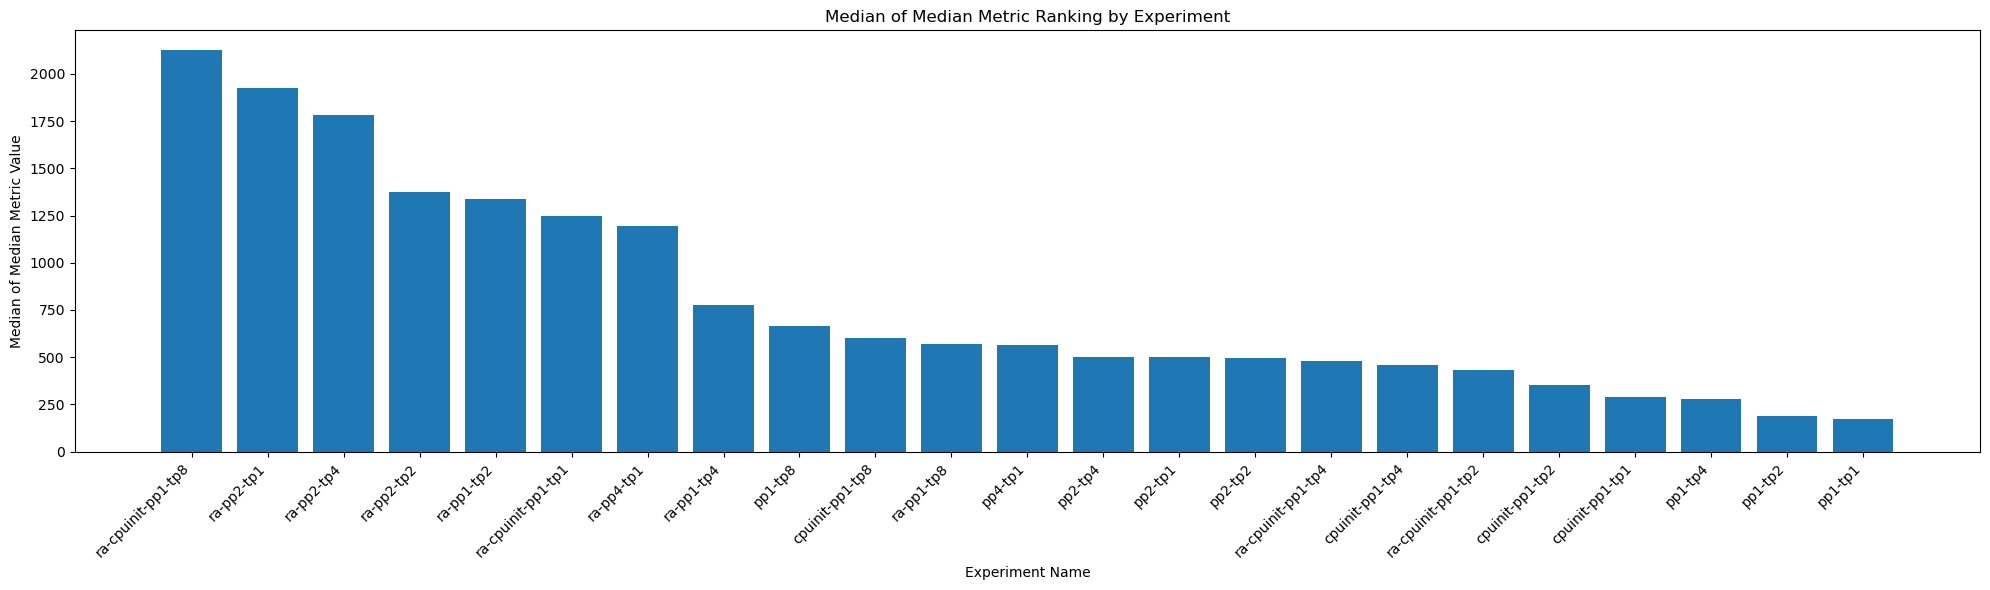

In [165]:
get_global_rankings(succeeded["ntwk"], 'send', "median", "median")

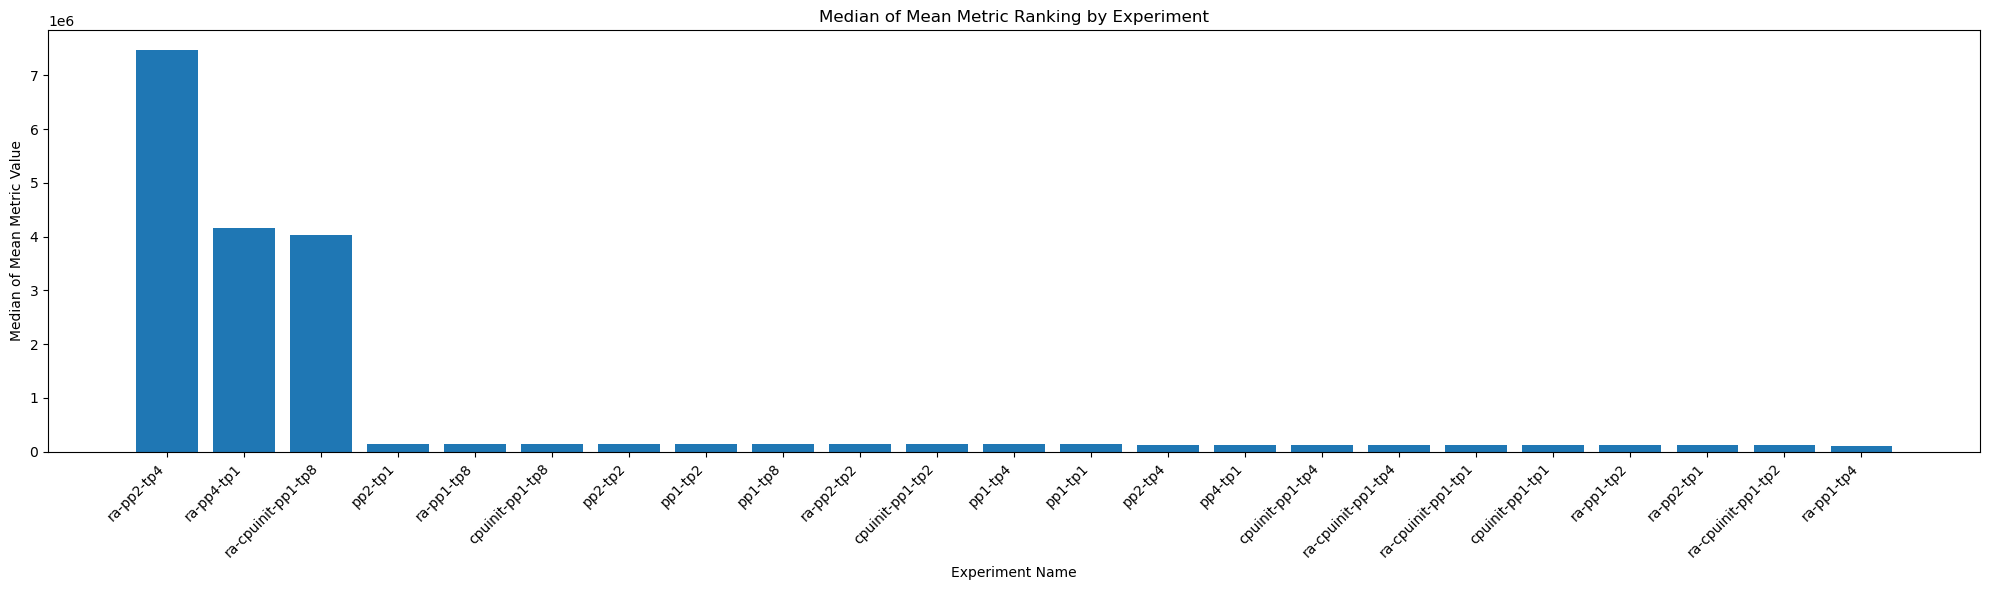

In [161]:
get_global_rankings(succeeded["ntwk"], 'recv', "mean", "median")

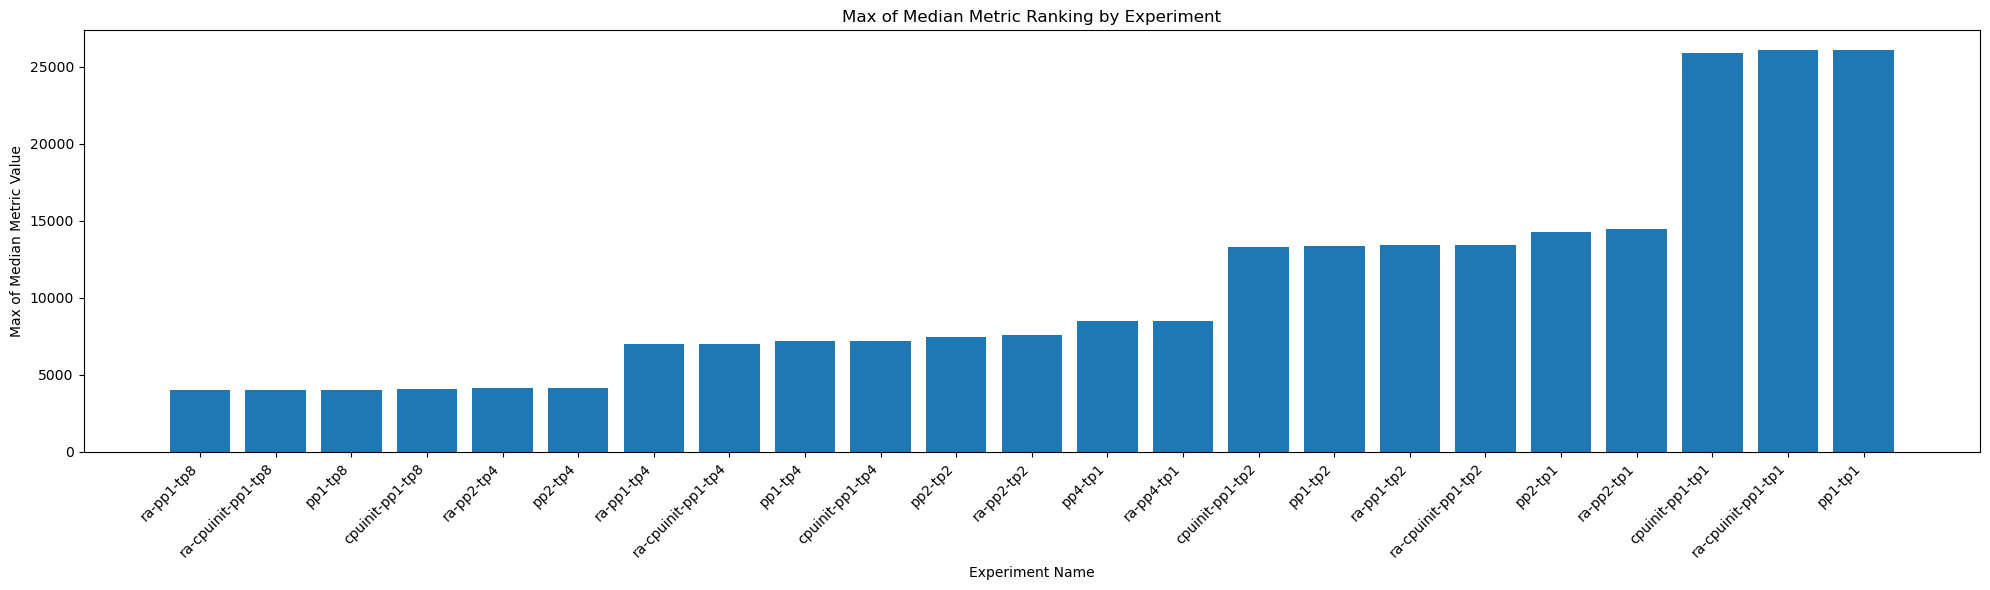

In [163]:
get_global_rankings(succeeded["gpu"], 'memory.used [MiB]', "median", "max", reverse=False)

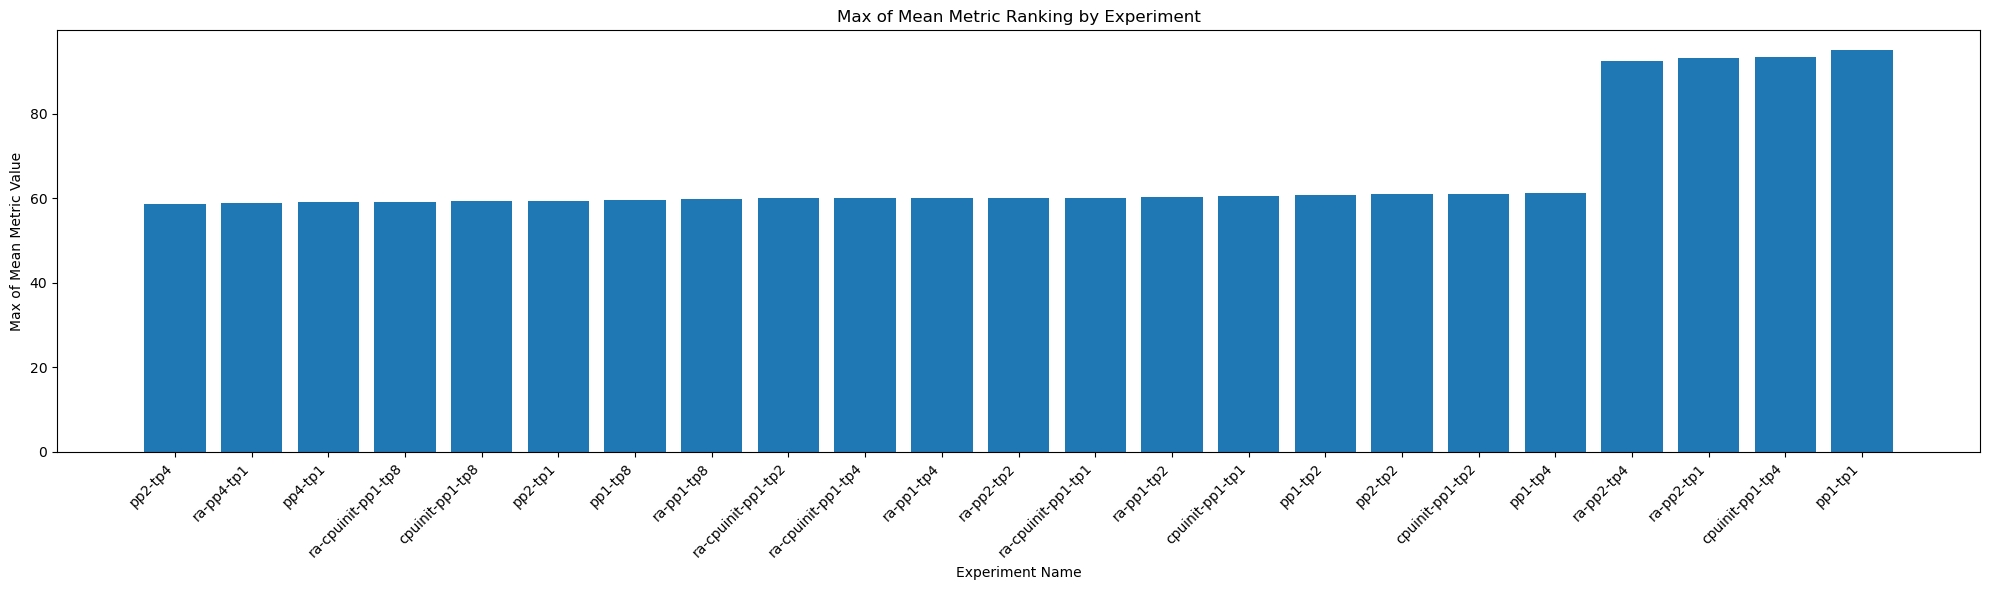

In [167]:
get_global_rankings(succeeded["gpu"], 'utilization.gpu [%]', "mean", "max", reverse=False)

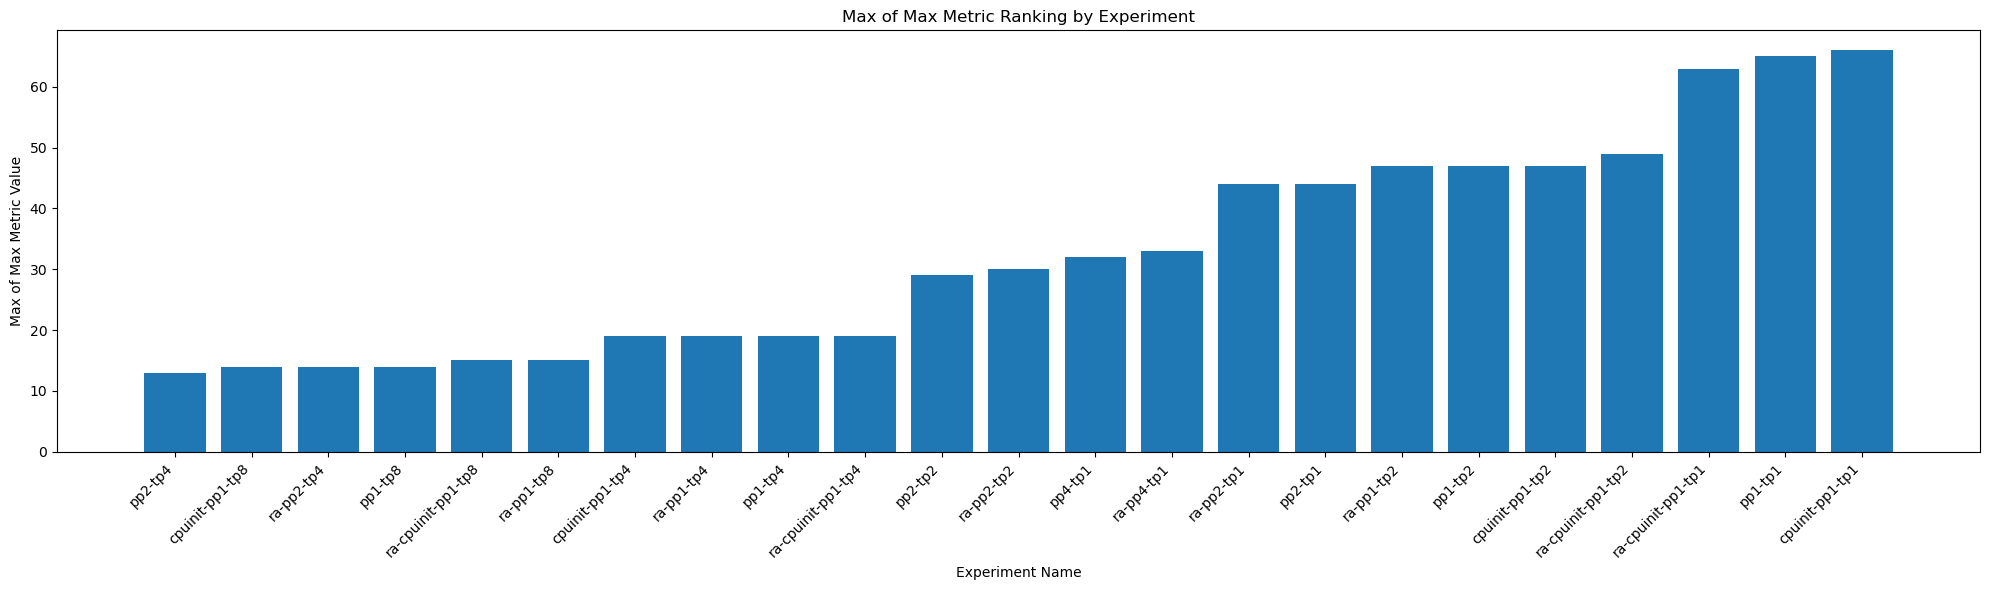

In [170]:
get_global_rankings(succeeded["gpu"], 'utilization.memory [%]', "max", "max", reverse=False)